In [1]:
import tensorflow as tf

tf.config.experimental_run_functions_eagerly(True)
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            # tf.config.experimental.set_virtual_device_configuration(gpu, [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.
1 Physical GPUs, 1 Logical GPUs
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10041473123165414785
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7021297664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13167793807367322339
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1070 Ti, pci bus id: 0000:05:00.0, compute capability: 6.1"
]


In [2]:
import pandas as pd
import numpy as np
from datetime import date
from sklearn import preprocessing

In [3]:
GAME = "dgrad"
NUM_LIM = (1, 49)
DGRAD_LIM = (1, 7)
TRAINING_FRAC = 0.6


In [4]:
df = pd.read_csv("data/daily_grand/DailyGrand.csv", index_col=0)
df.reset_index(drop=True, inplace=True)
df.drop(["DRAW NUMBER", "PRIZE DIVISION", "SEQUENCE NUMBER"], axis=1, inplace=True)
df.columns = ["date", "n1", "n2", "n3", "n4", "n5", "ngrand"]

df.drop_duplicates(subset='date', inplace=True, keep='first')
df.date = pd.to_datetime(df.date).dt.normalize()
df.set_index("date", inplace=True)

assert not (df.ngrand==0).any() # no duplicates with promotions!
df


,n1,n2,n3,n4,n5,ngrand
date,,,,,,
2016-10-20,8,14,18,35,37,5
2016-10-24,8,9,28,36,48,1
2016-10-27,5,14,24,30,34,7
2016-10-31,3,14,25,30,45,2
2016-11-03,9,12,19,24,39,4
...,...,...,...,...,...,...
2021-09-23,2,3,5,32,38,4
2021-09-27,1,12,26,34,35,1
2021-09-30,17,18,25,39,44,2


In [5]:
df['day_week'] = df.index.weekday
df['day_month'] = df.index.month
df['day_year'] = df.index.dayofyear
# df['week_year'] = df.index.isocalendar().week
df

,n1,n2,n3,n4,n5,ngrand,day_week,day_month,day_year
date,,,,,,,,,
2016-10-20,8,14,18,35,37,5,3,10,294
2016-10-24,8,9,28,36,48,1,0,10,298
2016-10-27,5,14,24,30,34,7,3,10,301
2016-10-31,3,14,25,30,45,2,0,10,305
2016-11-03,9,12,19,24,39,4,3,11,308
...,...,...,...,...,...,...,...,...,...
2021-09-23,2,3,5,32,38,4,3,9,266
2021-09-27,1,12,26,34,35,1,0,9,270
2021-09-30,17,18,25,39,44,2,3,9,273


In [6]:
num_col = [x for x in df.columns if x != "ngrand"]
ngrand_col = [x for x in df if x not in num_col]

scaler = preprocessing.StandardScaler()
df_scaled_values = scaler.fit_transform(df.values)
df_scaled = pd.DataFrame(df_scaled_values, index = df.index, columns=df.columns)
df_scaled.describe()

# df_scaled[num_col] = (df[num_col] - NUM_LIM[0]) / (NUM_LIM[1] - NUM_LIM[0])
# df_scaled[ngrand_col] = (df[ngrand_col] - DGRAD_LIM[0]) / (DGRAD_LIM[1] - DGRAD_LIM[0])


,n1,n2,n3,n4,n5,ngrand,day_week,day_month,day_year
count,5.190000e+02,5.190000e+02,5.190000e+02,5.190000e+02,5.190000e+02,5.190000e+02,5.190000e+02,5.190000e+02,5.190000e+02
mean,-9.412295e-18,-1.364783e-16,-3.251520e-17,5.561811e-17,2.786253e-16,-4.791714e-17,3.294303e-17,1.172259e-16,-5.454853e-17
std,1.000965e+00,1.000965e+00,1.000965e+00,1.000965e+00,1.000965e+00,1.000965e+00,1.000965e+00,1.000965e+00,1.000965e+00
min,-1.099387e+00,-1.734116e+00,-2.343871e+00,-3.074098e+00,-5.258143e+00,-1.345928e+00,-1.001929e+00,-1.599526e+00,-1.722439e+00
25%,-7.830126e-01,-7.844917e-01,-7.377592e-01,-6.285071e-01,-4.774998e-01,-8.635134e-01,-1.001929e+00,-7.284306e-01,-8.645344e-01
50%,-3.084503e-01,-7.227387e-02,1.175958e-02,1.866897e-01,2.935717e-01,1.013164e-01,9.980751e-01,1.426650e-01,-6.630243e-03
75%,6.406744e-01,7.586469e-01,7.612784e-01,7.689732e-01,7.562146e-01,1.066146e+00,9.980751e-01,7.233954e-01,8.560137e-01
max,3.804423e+00,3.014003e+00,2.367390e+00,1.700627e+00,1.064643e+00,1.548561e+00,9.980751e-01,1.594491e+00,1.737617e+00


In [7]:
n_train = int(len(df_scaled) * TRAINING_FRAC)
df_train = df_scaled.iloc[:n_train]
df_test = df_scaled.iloc[n_train:]

# Machine Learning

In [8]:
SEQ_LEN = 10

In [9]:
def timeseries_to_sequences(data, targets, seq_len, bs=1024):
    from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

    # data.shape, targets.shape
    L, D = data.shape
    N = L - seq_len + 1
    n_class = targets.shape[1] if targets.ndim == 2 else 1

    data_gen = np.append(data, [np.nan] * D).reshape(-1, D)
    targets_gen = np.append(np.empty(shape=(n_class)), targets).reshape(-1, n_class)
    targets = np.empty((N, n_class), dtype=np.float32)

    gen = TimeseriesGenerator(data_gen, targets_gen, seq_len, batch_size=bs)
    data = np.empty((N, seq_len, D), dtype=np.float32)

    for i in range(len(gen)):
        data[i * bs : (i + 1) * bs], targets[i * bs : (i + 1) * bs] = gen[i]

    assert data.shape == (N, seq_len, D)
    return data, targets

In [10]:
x_train, y_train = df_train.copy(), df_train.copy()
x_test, y_test = df_test.copy(), df_test.copy()

x_train = x_train.shift(1)
x_test = x_test.shift(1)

x_train.dropna(inplace=True)
x_test.dropna(inplace=True)

y_train = y_train.iloc[-len(x_train):]
y_test = y_test.iloc[-len(x_test):]

y_train.drop(['day_week','day_month','day_year'], axis=1, inplace=True)
y_test.drop(['day_week','day_month','day_year'], axis=1, inplace=True)

x_train, y_train = timeseries_to_sequences(x_train, y_train, SEQ_LEN)
x_test, y_test = timeseries_to_sequences(x_test, y_test, SEQ_LEN)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
N, _, D = x_train.shape

(301, 10, 9) (301, 6) (198, 10, 9) (198, 6)


In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.activations import softmax
from tensorflow.keras.layers import (
    GRU,
    LSTM,
    Dense,
    Dropout,
    Input,
    Softmax,
)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import os

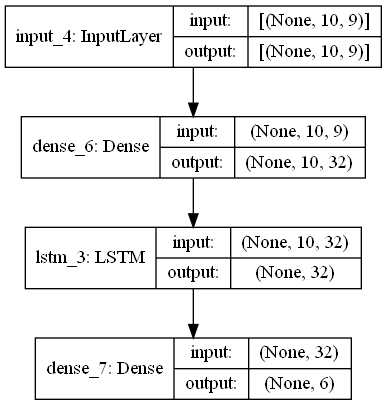

In [15]:
def build_model():

    inp = Input(shape=(SEQ_LEN, D))

    x = Dense(32)(inp)

    # for _ in range(2):
    #     x = LSTM(32, return_sequences=True)(x)
    #     # x = BatchNormalization()(x)
    #     x = Dropout(0.3)(x)
    x = LSTM(32)(x)
    # print(x.shape)

    
    # x = Dense(6)(x)
    x = Dense(6, activation='softmax', use_bias=False)(x)
    return Model(inp, x)


model = build_model()
plot_model(model, show_shapes=True)
#model.summary()

In [16]:
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(0.1, decay_steps=1000, decay_rate=0.9, staircase=False)
opt = tf.keras.optimizers.Adam(learning_rate=8e-4, decay=1e-6)
model.compile(loss="MSE", optimizer=opt)

In [17]:
r = model.fit(
    x_train,
    y_train,
    batch_size=N,
    verbose=2,
    # callbacks=[cp_callback, tensorboard_callback],
    initial_epoch=0,
    epochs=4000,
    validation_data=(x_test, y_test),
    shuffle=True,
)

C:\Users\SeanK\anaconda3\envs\ptf\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/4000
1/1 - 2s - loss: 1.0363 - val_loss: 1.0298
Epoch 2/4000
1/1 - 0s - loss: 1.0357 - val_loss: 1.0297
Epoch 3/4000
1/1 - 0s - loss: 1.0351 - val_loss: 1.0297
Epoch 4/4000
1/1 - 0s - loss: 1.0346 - val_loss: 1.0297
Epoch 5/4000
1/1 - 0s - loss: 1.0340 - val_loss: 1.0297
Epoch 6/4000
1/1 - 0s - loss: 1.0335 - val_loss: 1.0297
Epoch 7/4000
1/1 - 0s - loss: 1.0330 - val_loss: 1.0298
Epoch 8/4000
1/1 - 0s - loss: 1.0325 - val_loss: 1.0299
Epoch 9/4000
1/1 - 0s - loss: 1.0320 - val_loss: 1.0299
Epoch 10/4000
1/1 - 0s - loss: 1.0315 - val_loss: 1.0301
Epoch 11/4000
1/1 - 0s - loss: 1.0311 - val_loss: 1.0302
Epoch 12/4000
1/1 - 0s - loss: 1.0306 - val_loss: 1.0303
Epoch 13/4000
1/1 - 0s - loss: 1.0302 - val_loss: 1.0305
Epoch 14/4000
1/1 - 0s - loss: 1.0297 - val_loss: 1.0306
Epoch 15/4000
1/1 - 0s - loss: 1.0293 - val_loss: 1.0308
Epoch 16/4000
1/1 - 0s - loss: 1.0289 - val_loss: 1.0310
Epoch 17/4000
1/1 - 0s - loss: 1.0284 - val_loss: 1.0312
Epoch 18/4000
1/1 - 0s - loss: 1.0280 - 

In [23]:
y_pred_scaled = model.predict(x_test)
#y_pred = scaler.inverse_transform(y_pred_scaled)
#model.evaluate(x_test, y_test, use_multiprocessing=True)
y_pred.shape
scaler.

C:\Users\SeanK\anaconda3\envs\ptf\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


9